
# ================================================================
# PROYECTO: CLASIFICADOR DE LETRAS MINÚSCULAS GRIEGAS
# ================================================================


In [199]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import cv2
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

In [200]:
# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten,
                                   Dense, BatchNormalization, GlobalAveragePooling2D)


In [201]:

# Configuración para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Configuración de GPU (si está disponible)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

GPU disponible: []


================================================================
## SECCIÓN 2: CONFIGURACIÓN DE PARÁMETROS DEL PROYECTO
================================================================


In [202]:
# Parámetros del dataset
IMG_HEIGHT = 64  # Reducimos de 350 a 128 para eficiencia computacional
IMG_WIDTH = 64   # Mantenemos aspecto cuadrado
NUM_CLASSES = 6  # 6 letras minúsculas
BATCH_SIZE = 32   # Tamaño de lote apropiado para memoria
EPOCHS = 10      # Número máximo de épocas (se usará early stopping)

# Parámetros de entrenamiento
LEARNING_RATE = 0.001  # Tasa de aprendizaje inicial
VALIDATION_SPLIT = 0.2 # 20% de datos de entrenamiento para validación

In [121]:
!pip install -q gdown

# Descargar el archivo ZIP con el ID correcto
!gdown --id 1kOl0cg3DSMhdHnIHbOELiARBst8tt6TY -O archive.zip
!unzip -q archive.zip -d letras_datag
!ls letras_datag

# https://drive.google.com/file/d/1kOl0cg3DSMhdHnIHbOELiARBst8tt6TY/view?usp=sharing

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kOl0cg3DSMhdHnIHbOELiARBst8tt6TY
To: /content/archive.zip
100% 1.10M/1.10M [00:00<00:00, 13.2MB/s]
Set-Original


In [203]:
import os
import cv2
import numpy as np

X = []
y = []

base_dir = 'letras_datag/Set-Original/Dataset'

for letra in sorted(os.listdir(base_dir)):
    ruta_letra = os.path.join(base_dir, letra)
    if not os.path.isdir(ruta_letra):
        continue

    # for tipo in ['may', 'min']:
    #     ruta_tipo = os.path.join(ruta_letra, tipo)
    #     if not os.path.isdir(ruta_tipo):
    #         continue

    for archivo in os.listdir(ruta_letra):
        if archivo.endswith('.png'):
            img_path = os.path.join(ruta_letra, archivo)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))
            img = img / 255.0

            etiqueta = letra.lower()

            X.append(img)
            y.append(etiqueta)

X = np.array(X)
y = np.array(y)

np.save('X_letras.npy', X)
np.save('y_letras.npy', y)

print("Guardado exitoso:", X.shape, y.shape)

Guardado exitoso: (2400, 28, 28) (2400,)


Shape de X: (2400, 28, 28)
Shape de y: (2400,)
Etiquetas únicas: ['alpha' 'epsilon' 'kappa' 'nu' 'rho' 'upsilon']


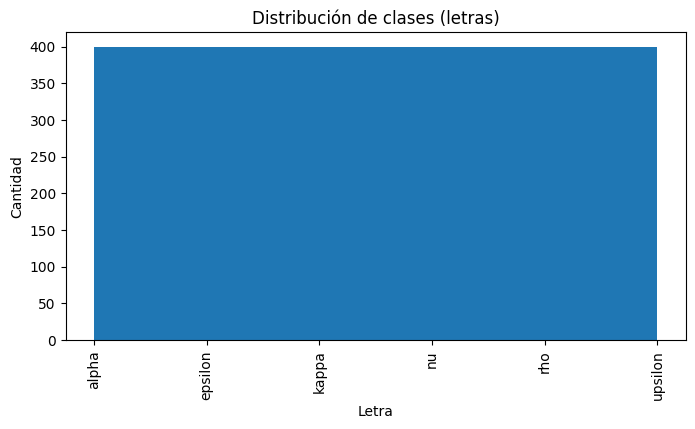

In [204]:
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)
print("Etiquetas únicas:", np.unique(y))

# Histograma de distribución de clases
plt.figure(figsize=(8,4))
plt.hist(y, bins=len(np.unique(y)))
plt.title("Distribución de clases (letras)")
plt.xlabel("Letra")
plt.ylabel("Cantidad")
plt.xticks(rotation=90)
plt.show()

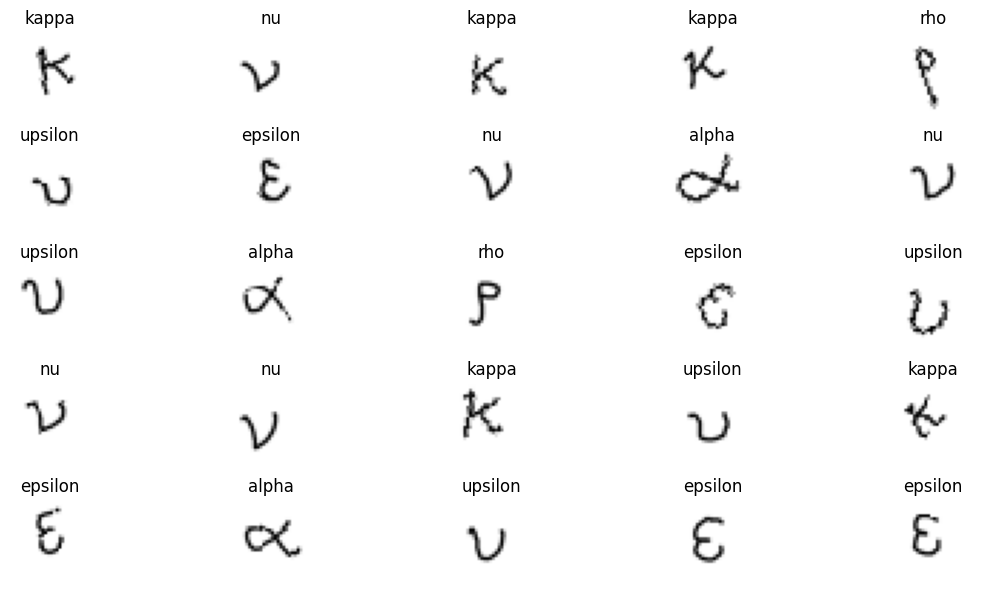

In [205]:
plt.figure(figsize=(12,6))
for i in range(25):
    idx = np.random.randint(0, X.shape[0])
    plt.subplot(5,5,i+1)
    plt.title(y[idx])
    plt.imshow(X[idx], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [206]:
import numpy as np

X = np.load('X_letras.npy')
y = np.load('y_letras.npy')

print(X.shape)  # (N, 28, 28)
print(y.shape)  # (N,)
print(np.unique(y))  # Verifica letras disponibles

(2400, 28, 28)
(2400,)
['alpha' 'epsilon' 'kappa' 'nu' 'rho' 'upsilon']


In [207]:
from sklearn.preprocessing import LabelEncoder
# Convertir letras a números únicos (ej. 'A'→0, 'b'→1, ...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Puedes revertir con: le.inverse_transform([0, 1, 2, ...])

In [217]:
from sklearn.model_selection import train_test_split

# Separar 80% entrenamiento, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Expandir dimensión para canal (grises)
if X_train.ndim == 3:
    X_train = X_train[..., None]
    X_test = X_test[..., None]

In [218]:
num_clases = len(np.unique(y_encoded))  # Total de letras
print(num_clases)

6


In [223]:
def create_cnn_model(input_shape, num_classes):


    model = Sequential([
        # ============ BLOQUE CONVOLUCIONAL 1 ============
        # Primer conjunto: detección de características básicas
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
               padding='same', name='conv1_1'),
        BatchNormalization(name='bn1_1'),  # Normalización para estabilidad
        Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),
        BatchNormalization(name='bn1_2'),
        MaxPooling2D((2, 2), name='pool1'),  # Reducir dimensionalidad
        Dropout(0.25, name='dropout1'),      # Regularización

        # ============ BLOQUE CONVOLUCIONAL 2 ============
        # Segundo conjunto: características de nivel medio
        Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'),
        BatchNormalization(name='bn2_1'),
        Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'),
        BatchNormalization(name='bn2_2'),
        MaxPooling2D((2, 2), name='pool2'),
        Dropout(0.2, name='dropout2'),

        # ============ BLOQUE CONVOLUCIONAL 3 ============
        # Tercer conjunto: características de alto nivel
        Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'),
        BatchNormalization(name='bn3_1'),
        Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2'),
        BatchNormalization(name='bn3_2'),
        MaxPooling2D((2, 2), name='pool3'),
        Dropout(0.2, name='dropout3'),

        # # ============ BLOQUE CONVOLUCIONAL 4 ============
        # # Cuarto conjunto: características muy específicas
        # Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1'),
        # BatchNormalization(name='bn4_1'),
        # Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_2'),
        # BatchNormalization(name='bn4_2'),
        # MaxPooling2D((2, 2), name='pool4'),
        # Dropout(0.4, name='dropout4'),

        # ============ CAPAS DENSAS ============
        # Global Average Pooling en lugar de Flatten para reducir parámetros
        GlobalAveragePooling2D(name='global_avg_pool'),

        # Capa densa intermedia con regularización fuerte
        # Dense(512, activation='relu', name='dense1'),
        Dense(128, activation='relu', name='dense1'),
        BatchNormalization(name='bn_dense1'),
        # Dropout(0.5, name='dropout_dense1'),
        Dropout(0.2, name='dropout_dense1'),

        # Dense(256, activation='relu', name='dense2'),
        Dense(64, activation='relu', name='dense2'),
        BatchNormalization(name='bn_dense2'),
        # Dropout(0.5, name='dropout_dense2'),
        Dropout(0.3, name='dropout_dense2'),

        # Capa de salida para clasificación
        Dense(num_classes, activation='softmax', name='output')
    ])

    return model

In [230]:
# Crear el modelo
print("\n" + "="*50)
print("CONSTRUCCIÓN DEL MODELO CNN")
print("="*50)

input_shape = X_train.shape[1:] # Get (28, 28, 1) from X_train shape
model = create_cnn_model(input_shape, NUM_CLASSES)

# Mostrar arquitectura del modelo
print("Arquitectura del modelo:")
model.summary()

# Visualizar arquitectura del modelo
tf.keras.utils.plot_model(model, to_file='model_architecture.png',
                          show_shapes=True, show_layer_names=True,
                          rankdir='TB', dpi=150)

# Contar parámetros del modelo
total_params = model.count_params()
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"\nParámetros del modelo:")
print(f"  Total: {total_params:,}")
print(f"  Entrenables: {trainable_params:,}")


CONSTRUCCIÓN DEL MODELO CNN
Arquitectura del modelo:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense1 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense2 (BatchNormalization)  │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 314,150 (1.20 MB)

 Trainable params: 312,870 (1.19 MB)

 Non-trainable params: 1,280 (5.00 KB)


Parámetros del modelo:
  Total: 314,150
  Entrenables: 312,870


In [231]:
# Configurar optimizador Adam con tasa de aprendizaje adaptativa
optimizer = optimizers.Adam(
    learning_rate=LEARNING_RATE,
    beta_1=0.9,      # Momento para gradientes
    beta_2=0.999,    # Momento para gradientes cuadrados
    epsilon=1e-7     # Pequeño valor para estabilidad numérica
)

# Compilar modelo con métricas apropiadas

from tensorflow.keras.metrics import TopKCategoricalAccuracy

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Función de pérdida para clasificación multiclase
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]  # Precisión y top-3 precisión
)

print("✓ Modelo compilado exitosamente")
print(f"  Optimizador: Adam (lr={LEARNING_RATE})")
print(f"  Función de pérdida: categorical_crossentropy")
print(f"  Métricas: ['accuracy', 'top_3_accuracy']")

✓ Modelo compilado exitosamente
  Optimizador: Adam (lr=0.001)
  Función de pérdida: categorical_crossentropy
  Métricas: ['accuracy', 'top_3_accuracy']


In [238]:
def create_callbacks():
    """
    Crea callbacks para mejorar el entrenamiento y prevenir overfitting.

    Returns:
        list: Lista de callbacks configurados
    """

    # Early Stopping: detiene entrenamiento si no hay mejora
    early_stopping = callbacks.EarlyStopping(
        monitor='val_accuracy',    # Métrica a monitorear
        patience=15,               # Épocas sin mejora antes de parar
        restore_best_weights=True, # Restaurar mejores pesos
        verbose=1,
        mode='max'                 # Maximizar accuracy
    )

    # Reducir tasa de aprendizaje cuando se estanque
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',        # Monitorear pérdida de validación
        factor=0.2,               # Reducir lr por este factor
        patience=8,               # Épocas sin mejora antes de reducir
        min_lr=1e-7,              # Tasa mínima de aprendizaje
        verbose=1
    )

    # Guardar mejor modelo
    model_checkpoint = callbacks.ModelCheckpoint(
        'best_letter_classifier.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'
    )

    # Registro de métricas para visualización
    csv_logger = callbacks.CSVLogger(
        'training_log.csv',
        append=True
    )

    return [early_stopping, reduce_lr, model_checkpoint, csv_logger]

# Crear callbacks
callback_list = create_callbacks()

print("Callbacks configurados:")
for callback in callback_list:
    print(f"  - {callback.__class__.__name__}")

Callbacks configurados:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint
  - CSVLogger


In [239]:
# Convert integer labels to one-hot encoded vectors
# This is required when using 'categorical_crossentropy' as the loss function
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

print("Shape de y_train_cat:", y_train_cat.shape)
print("Shape de y_test_cat:", y_test_cat.shape)

print("\n" + "="*60)
print("INICIANDO ENTRENAMIENTO DEL MODELO")
print("="*60)

# Calcular pasos por época
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_test) // BATCH_SIZE

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(f"Configuración de entrenamiento:")
print(f"  Épocas máximas: {EPOCHS}")
print(f"  Pasos por época: {steps_per_epoch}")
print(f"  Pasos de validación: {validation_steps}")
print(f"  Tamaño de lote: {BATCH_SIZE}")

# Entrenar el modelo
history = model.fit(
    X_train, y_train_cat,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=(X_test,y_test_cat),
    validation_steps=validation_steps,
    callbacks=callback_list,
    # class_weight=class_weight_dict,  # Usar pesos de clase para balancear
    verbose=1
)

print("\n✓ Entrenamiento completado!")

Shape de y_train_cat: (1920, 6)
Shape de y_test_cat: (480, 6)

INICIANDO ENTRENAMIENTO DEL MODELO
(1920, 28, 28, 1)
(1920,)
(480, 28, 28, 1)
(480,)
Configuración de entrenamiento:
  Épocas máximas: 10
  Pasos por época: 60
  Pasos de validación: 15
  Tamaño de lote: 32
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9877 - loss: 0.0495 - top_3_accuracy: 0.9996
Epoch 1: val_accuracy improved from -inf to 0.95625, saving model to best_letter_classifier.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - accuracy: 0.9876 - loss: 0.0494 - top_3_accuracy: 0.9996 - val_accuracy: 0.9563 - val_loss: 0.1496 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9867 - loss: 0.0373 - top_3_accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.95625 to 0.97500, saving model to best_letter_classifier.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.9867 - loss: 0.0373 - top_3_accuracy: 1.0000 - val_accuracy: 0.9750 - val_loss: 0.0884 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9922 - loss: 0.0334 - top_3_accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.97500 to 0.98958, saving model to best_letter_classifier.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.9922 - loss: 0.0334 - top_3_accuracy: 1.0000 - val_accuracy: 0.9896 - val_loss: 0.0337 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9906 - loss: 0.0301 - top_3_accuracy: 1.0000
Epoch 4: val_accuracy improved from 0.98958 to 0.99167, saving model to best_letter_classifier.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - accuracy: 0.9906 - loss: 0.0300 - top_3_accuracy: 1.0000 - val_accuracy: 0.9917 - val_loss: 0.0221 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9958 - loss: 0.0168 - top_3_accuracy: 1.0000
Epoch 5: val_accuracy did not improve from 0.99167
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.9958 - loss: 0.0168 - top_3_accuracy: 1.0000 - val_accuracy: 0.9896 - val_loss: 0.0343 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9957 - loss: 0.0194 - top_3_accuracy: 1.0000
Epoch 6: val_accuracy did not improve from 0.99167
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - accuracy: 0.9957 - loss: 0.0196 - top_3_accuracy: 1.0000 - val_accuracy: 0.9708 - val_loss: 0.1072 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9919 - loss: 0.0254 - 

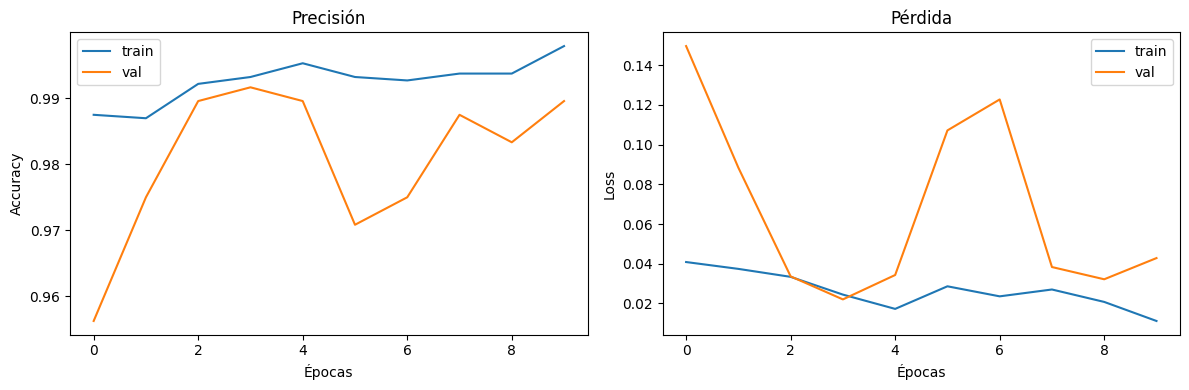

In [240]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Precisión')
plt.xlabel('Épocas'); plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Pérdida')
plt.xlabel('Épocas'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


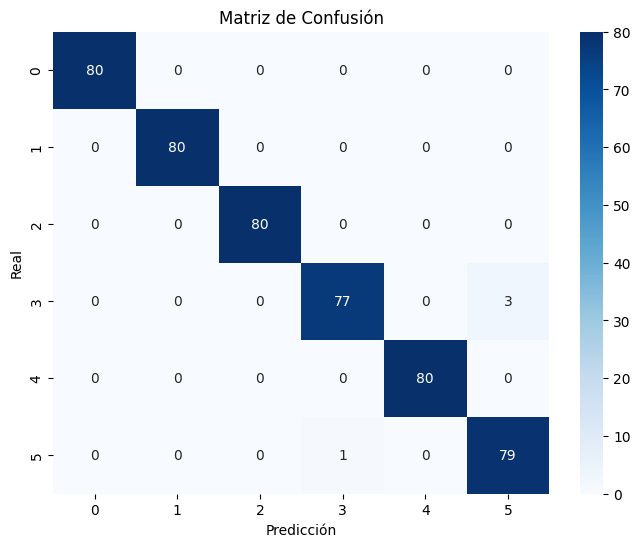

Accuracy: 0.992


In [241]:
# Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Hacer predicciones
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convertir a clases

# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Mostrar accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy:.3f}")